# Byte-Pair Encoding tokenization

Install the Transformers, Datasets, and Evaluate libraries to run this notebook.

In [ ]:
!pip install datasets evaluate transformers[sentencepiece]

Byte-Pair Encoding (BPE) was initially developed as an algorithm to compress texts, and then used by OpenAI for tokenization when pretraining the GPT model. It’s used by a lot of Transformer models, including **GPT, GPT-2, RoBERTa, BART, and DeBERTa**.

In [1]:
from IPython.display import HTML

HTML('<iframe width="430" height="320" src="https://www.youtube.com/embed/HEikzVL-lZU" title="Byte Pair Encoding Tokenization" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

/home/hpshin/.local/lib/python3.6/site-packages/IPython/core/display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


This section covers BPE in depth, going as far as showing a full implementation. You can skip to the end if you just want a general overview of the tokenization algorithm.

## Training algorithm

BPE training starts by computing the **unique set of words** used in the corpus (after the normalization and pre-tokenization steps are completed), then building the vocabulary by taking all the symbols used to write those words. As a very simple example, let’s say our corpus uses these five words:

In [ ]:
"hug", "pug", "pun", "bun", "hugs"

The base vocabulary will then be ["b", "g", "h", "n", "p", "s", "u"]. For real-world cases, that base vocabulary will contain all the **ASCII characters**, at the very least, and **probably some Unicode characters as well**. If an example you are tokenizing uses a character that is not in the training corpus, that character will be converted to the unknown token. That’s one reason why lots of NLP models are very bad at analyzing content with emojis, for instance.

The **GPT-2 and RoBERTa** tokenizers (which are pretty similar) have a clever way to deal with this: they don’t look at words as being written with Unicode characters, but with **bytes**. **This way the base vocabulary has a small size (256), but every character you can think of will still be included and not end up being converted to the unknown token**. This trick is called **byte-level BPE.**

After getting this base vocabulary, we add new tokens until the desired vocabulary size is reached by learning merges, which are rules to merge two elements of the existing vocabulary together into a new one. So, at the beginning these merges will create tokens with two characters, and then, as training progresses, longer subwords.

At any step during the tokenizer training, the BPE algorithm will search for the most frequent pair of existing tokens (by “**pair**,” here we mean two consecutive tokens in a word). **That most frequent pair is the one that will be merged, and we rinse and repeat for the next step.**

Going back to our previous example, let’s assume the words had the following frequencies:

In [ ]:
("hug", 10), ("pug", 5), ("pun", 12), ("bun", 4), ("hugs", 5)

meaning "hug" was present 10 times in the corpus, "pug" 5 times, "pun" 12 times, "bun" 4 times, and "hugs" 5 times. We start the training by splitting each word into characters (the ones that form our initial vocabulary) so we can see each word as a list of tokens:

In [ ]:
("h" "u" "g", 10), ("p" "u" "g", 5), ("p" "u" "n", 12), ("b" "u" "n", 4), ("h" "u" "g" "s", 5)

Then we look at pairs. The pair ("h", "u") is present in the words "hug" and "hugs", so 15 times total in the corpus. It’s not the most frequent pair, though: that honor belongs to ("u", "g"), which is present in "hug", "pug", and "hugs", for a grand total of 20 times in the vocabulary.

Thus, the first merge rule learned by the tokenizer is ("u", "g") -> "ug", which means that "ug" will be added to the vocabulary, and the pair should be merged in all the words of the corpus. At the end of this stage, the vocabulary and corpus look like this:

In [ ]:
Vocabulary: ["b", "g", "h", "n", "p", "s", "u", "ug"]
Corpus: ("h" "ug", 10), ("p" "ug", 5), ("p" "u" "n", 12), ("b" "u" "n", 4), ("h" "ug" "s", 5)

Now we have some pairs that result in a token longer than two characters: the pair ("h", "ug"), for instance (present 15 times in the corpus). The most frequent pair at this stage is ("u", "n"), however, present 16 times in the corpus, so the second merge rule learned is ("u", "n") -> "un". Adding that to the vocabulary and merging all existing occurrences leads us to:

In [ ]:
Vocabulary: ["b", "g", "h", "n", "p", "s", "u", "ug", "un"]
Corpus: ("h" "ug", 10), ("p" "ug", 5), ("p" "un", 12), ("b" "un", 4), ("h" "ug" "s", 5)

Now the most frequent pair is ("h", "ug"), so we learn the merge rule ("h", "ug") -> "hug", which gives us our first three-letter token. After the merge, the corpus looks like this:

In [ ]:
Vocabulary: ["b", "g", "h", "n", "p", "s", "u", "ug", "un", "hug"]
Corpus: ("hug", 10), ("p" "ug", 5), ("p" "un", 12), ("b" "un", 4), ("hug" "s", 5)

And we continue like this until we reach the desired vocabulary size.

✏️ Now your turn! What do you think the next merge rule will be?

## Tokenization algorithm
Tokenization follows the training process closely, in the sense that new inputs are tokenized by applying the following steps:

 - 1.Normalization
 - 2. Pre-tokenization
 - 3.Splitting the words into individual characters
 - 4. Applying the merge rules learned in order on those splits

Let’s take the example we used during training, with the three merge rules learned:

In [ ]:
("u", "g") -> "ug"
("u", "n") -> "un"
("h", "ug") -> "hug"

The word "bug" will be tokenized as ["b", "ug"]. "mug", however, will be tokenized as ["[UNK]", "ug"] since the letter "m" was not in the base vocabulary. Likewise, the word "thug" will be tokenized as ["[UNK]", "hug"]: the letter "t" is not in the base vocabulary, and applying the merge rules results first in "u" and "g" being merged and then "hu" and "g" being merged.

✏️ Now your turn! How do you think the word "unhug" will be tokenized?

## Implementing BPE

Now let’s take a look at an implementation of the BPE algorithm. This won’t be an optimized version you can actually use on a big corpus; we just want to show you the code so you can understand the algorithm a little bit better.

First we need a corpus, so let’s create a simple one with a few sentences:

In [1]:
corpus = [
    "This is the Hugging Face Course.",
    "This chapter is about tokenization.",
    "This section shows several tokenizer algorithms.",
    "Hopefully, you will be able to understand how they are trained and generate tokens.",
]

Next, we need to pre-tokenize that corpus into words. Since we are replicating a BPE tokenizer (like GPT-2), we will use the gpt2 tokenizer for the pre-tokenization:

In [2]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("gpt2")

2023-05-18 17:02:38.473643: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-18 17:02:38.609570: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-18 17:02:38.639172: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-18 17:02:39.085303: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

Then we compute the frequencies of each word in the corpus as we do the pre-tokenization:

In [3]:
from collections import defaultdict

word_freqs = defaultdict(int)

for text in corpus:
    words_with_offsets = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)
    new_words = [word for word, offset in words_with_offsets]
    for word in new_words:
        word_freqs[word] += 1

print(word_freqs)

defaultdict(<class 'int'>, {'This': 3, 'Ġis': 2, 'Ġthe': 1, 'ĠHugging': 1, 'ĠFace': 1, 'ĠCourse': 1, '.': 4, 'Ġchapter': 1, 'Ġabout': 1, 'Ġtokenization': 1, 'Ġsection': 1, 'Ġshows': 1, 'Ġseveral': 1, 'Ġtokenizer': 1, 'Ġalgorithms': 1, 'Hopefully': 1, ',': 1, 'Ġyou': 1, 'Ġwill': 1, 'Ġbe': 1, 'Ġable': 1, 'Ġto': 1, 'Ġunderstand': 1, 'Ġhow': 1, 'Ġthey': 1, 'Ġare': 1, 'Ġtrained': 1, 'Ġand': 1, 'Ġgenerate': 1, 'Ġtokens': 1})


The next step is to compute the base vocabulary, formed by all the characters used in the corpus:

In [4]:
alphabet = []

for word in word_freqs.keys():
    for letter in word:
        if letter not in alphabet:
            alphabet.append(letter)
alphabet.sort()

print(alphabet)

[',', '.', 'C', 'F', 'H', 'T', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'y', 'z', 'Ġ']


We also add the special tokens used by the model at the beginning of that vocabulary. In the case of GPT-2, the only special token is "<|endoftext|>":

In [5]:
vocab = ["<|endoftext|>"] + alphabet.copy()

We now need to split each word into individual characters, to be able to start training:

In [6]:
splits = {word: [c for c in word] for word in word_freqs.keys()}

In [7]:
def compute_pair_freqs(splits):
    pair_freqs = defaultdict(int)
    for word, freq in word_freqs.items():
        split = splits[word]
        if len(split) == 1:
            continue
        for i in range(len(split) - 1):
            pair = (split[i], split[i + 1])
            pair_freqs[pair] += freq
    return pair_freqs

Let’s have a look at a part of this dictionary after the initial splits:

In [8]:
pair_freqs = compute_pair_freqs(splits)

for i, key in enumerate(pair_freqs.keys()):
    print(f"{key}: {pair_freqs[key]}")
    if i >= 5:
        break

('T', 'h'): 3
('h', 'i'): 3
('i', 's'): 5
('Ġ', 'i'): 2
('Ġ', 't'): 7
('t', 'h'): 3


Now, finding the most frequent pair only takes a quick loop:

In [9]:
best_pair = ""
max_freq = None

for pair, freq in pair_freqs.items():
    if max_freq is None or max_freq < freq:
        best_pair = pair
        max_freq = freq

print(best_pair, max_freq)

('Ġ', 't') 7


So the first merge to learn is ('Ġ', 't') -> 'Ġt', and we add 'Ġt' to the vocabulary:

In [10]:
merges = {("Ġ", "t"): "Ġt"}
vocab.append("Ġt")

To continue, we need to apply that merge in our splits dictionary. Let’s write another function for this:

In [11]:
def merge_pair(a, b, splits):
    for word in word_freqs:
        split = splits[word]
        if len(split) == 1:
            continue

        i = 0
        while i < len(split) - 1:
            if split[i] == a and split[i + 1] == b:
                split = split[:i] + [a + b] + split[i + 2 :]
            else:
                i += 1
        splits[word] = split
    return splits

And we can have a look at the result of the first merge:

In [12]:
splits = merge_pair("Ġ", "t", splits)
print(splits["Ġtrained"])

['Ġt', 'r', 'a', 'i', 'n', 'e', 'd']


Now we have everything we need to loop until we have learned all the merges we want. Let’s aim for a vocab size of 50:

In [13]:
vocab_size = 50

while len(vocab) < vocab_size:
    pair_freqs = compute_pair_freqs(splits)
    best_pair = ""
    max_freq = None
    for pair, freq in pair_freqs.items():
        if max_freq is None or max_freq < freq:
            best_pair = pair
            max_freq = freq
    splits = merge_pair(*best_pair, splits)
    merges[best_pair] = best_pair[0] + best_pair[1]
    vocab.append(best_pair[0] + best_pair[1])

As a result, we’ve learned 19 merge rules (the initial vocabulary had a size of 31 — 30 characters in the alphabet, plus the special token):

In [14]:
print(merges)

{('Ġ', 't'): 'Ġt', ('i', 's'): 'is', ('e', 'r'): 'er', ('Ġ', 'a'): 'Ġa', ('Ġt', 'o'): 'Ġto', ('e', 'n'): 'en', ('T', 'h'): 'Th', ('Th', 'is'): 'This', ('o', 'u'): 'ou', ('s', 'e'): 'se', ('Ġto', 'k'): 'Ġtok', ('Ġtok', 'en'): 'Ġtoken', ('n', 'd'): 'nd', ('Ġ', 'is'): 'Ġis', ('Ġt', 'h'): 'Ġth', ('Ġth', 'e'): 'Ġthe', ('i', 'n'): 'in', ('Ġa', 'b'): 'Ġab', ('Ġtoken', 'i'): 'Ġtokeni'}


And the vocabulary is composed of the special token, the initial alphabet, and all the results of the merges:

In [15]:
print(vocab)

['<|endoftext|>', ',', '.', 'C', 'F', 'H', 'T', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'y', 'z', 'Ġ', 'Ġt', 'is', 'er', 'Ġa', 'Ġto', 'en', 'Th', 'This', 'ou', 'se', 'Ġtok', 'Ġtoken', 'nd', 'Ġis', 'Ġth', 'Ġthe', 'in', 'Ġab', 'Ġtokeni']


**Using train_new_from_iterator() on the same corpus won’t result in the exact same vocabulary. This is because when there is a choice of the most frequent pair**, we selected the first one encountered, while the 🤗 Tokenizers library selects the first one based on its inner IDs.

In [ ]:
def tokenize(text):
    pre_tokenize_result = tokenizer._tokenizer.pre_tokenizer.pre_tokenize_str(text)
    pre_tokenized_text = [word for word, offset in pre_tokenize_result]
    splits = [[l for l in word] for word in pre_tokenized_text]
    for pair, merge in merges.items():
        for idx, split in enumerate(splits):
            i = 0
            while i < len(split) - 1:
                if split[i] == pair[0] and split[i + 1] == pair[1]:
                    split = split[:i] + [merge] + split[i + 2 :]
                else:
                    i += 1
            splits[idx] = split

    return sum(splits, [])

We can try this on any text composed of characters in the alphabet:

In [ ]:
tokenize("This is not a token.")

['This', 'Ġis', 'Ġ', 'n', 'o', 't', 'Ġa', 'Ġtoken', '.']

 Our implementation will throw an error if there is an unknown character since we didn’t do anything to handle them. GPT-2 doesn’t actually have an unknown token (it’s impossible to get an unknown character when using byte-level BPE), but this could happen here because we did not include all the possible bytes in the initial vocabulary. This aspect of BPE is beyond the scope of this section, so we’ve left the details out.

That’s it for the BPE algorithm! Next, we’ll have a look at WordPiece.

### Supplement: Byte-level Byte Pair Encoding
- Changhan Wang et al. (2019) [Neural Machine Translation with Byte-Level Subwords](https://arxiv.org/abs/1909.03341)

- Byte(E3, 81, AE...)
    - Compactness: 256개의 토큰만 있으면 뭐든 만들 수 있음
    - 언어에 상관 없이 사용할 수 있음

#### Character-level BPE의 한계

- Vocabulary에서 character가 너무 많은 슬롯을 차지할 수 있음
    - Rare character from noisy text
    - Character-rich languages (such as CJK languages)

- 여러 언어를 다루기에 부적합함
    - bilingual and multilingual
    - 150개의 언어를 커버하려면 138K의 유니코드 character가 필요함 반면, UTF-8 byte는 256개 중에 248개만 있으면 다 커버할 수 있음

#### Byte-level BPE (BBPE)

- 기본적으로 유니코드 character를 UTF-8로 인코딩함
    - 유니코드 = 1~4 byte
    - 인코딩 된 sequence of bytes에 대해서 BPE 학습을 시킴
    - 최종 vocab: UTF-8 byte set + BPE를 통해 추가 되는 variable-length n-gram bytes
    - Byte Sequence: EA B0 80 EB 82 98 EB 8B A4 EB 9D BC EB A7 88 EB B0 94 EC 82 AC 
    - Byte set: EA, B0, 80, EB, 82, 98, 8B, A4, 9D, BC, A7, 88, B0, 94, EC, 82, AC 
    - Variable-length n-gram bytes: EA B0, EB 82 98, A4 EB, ...

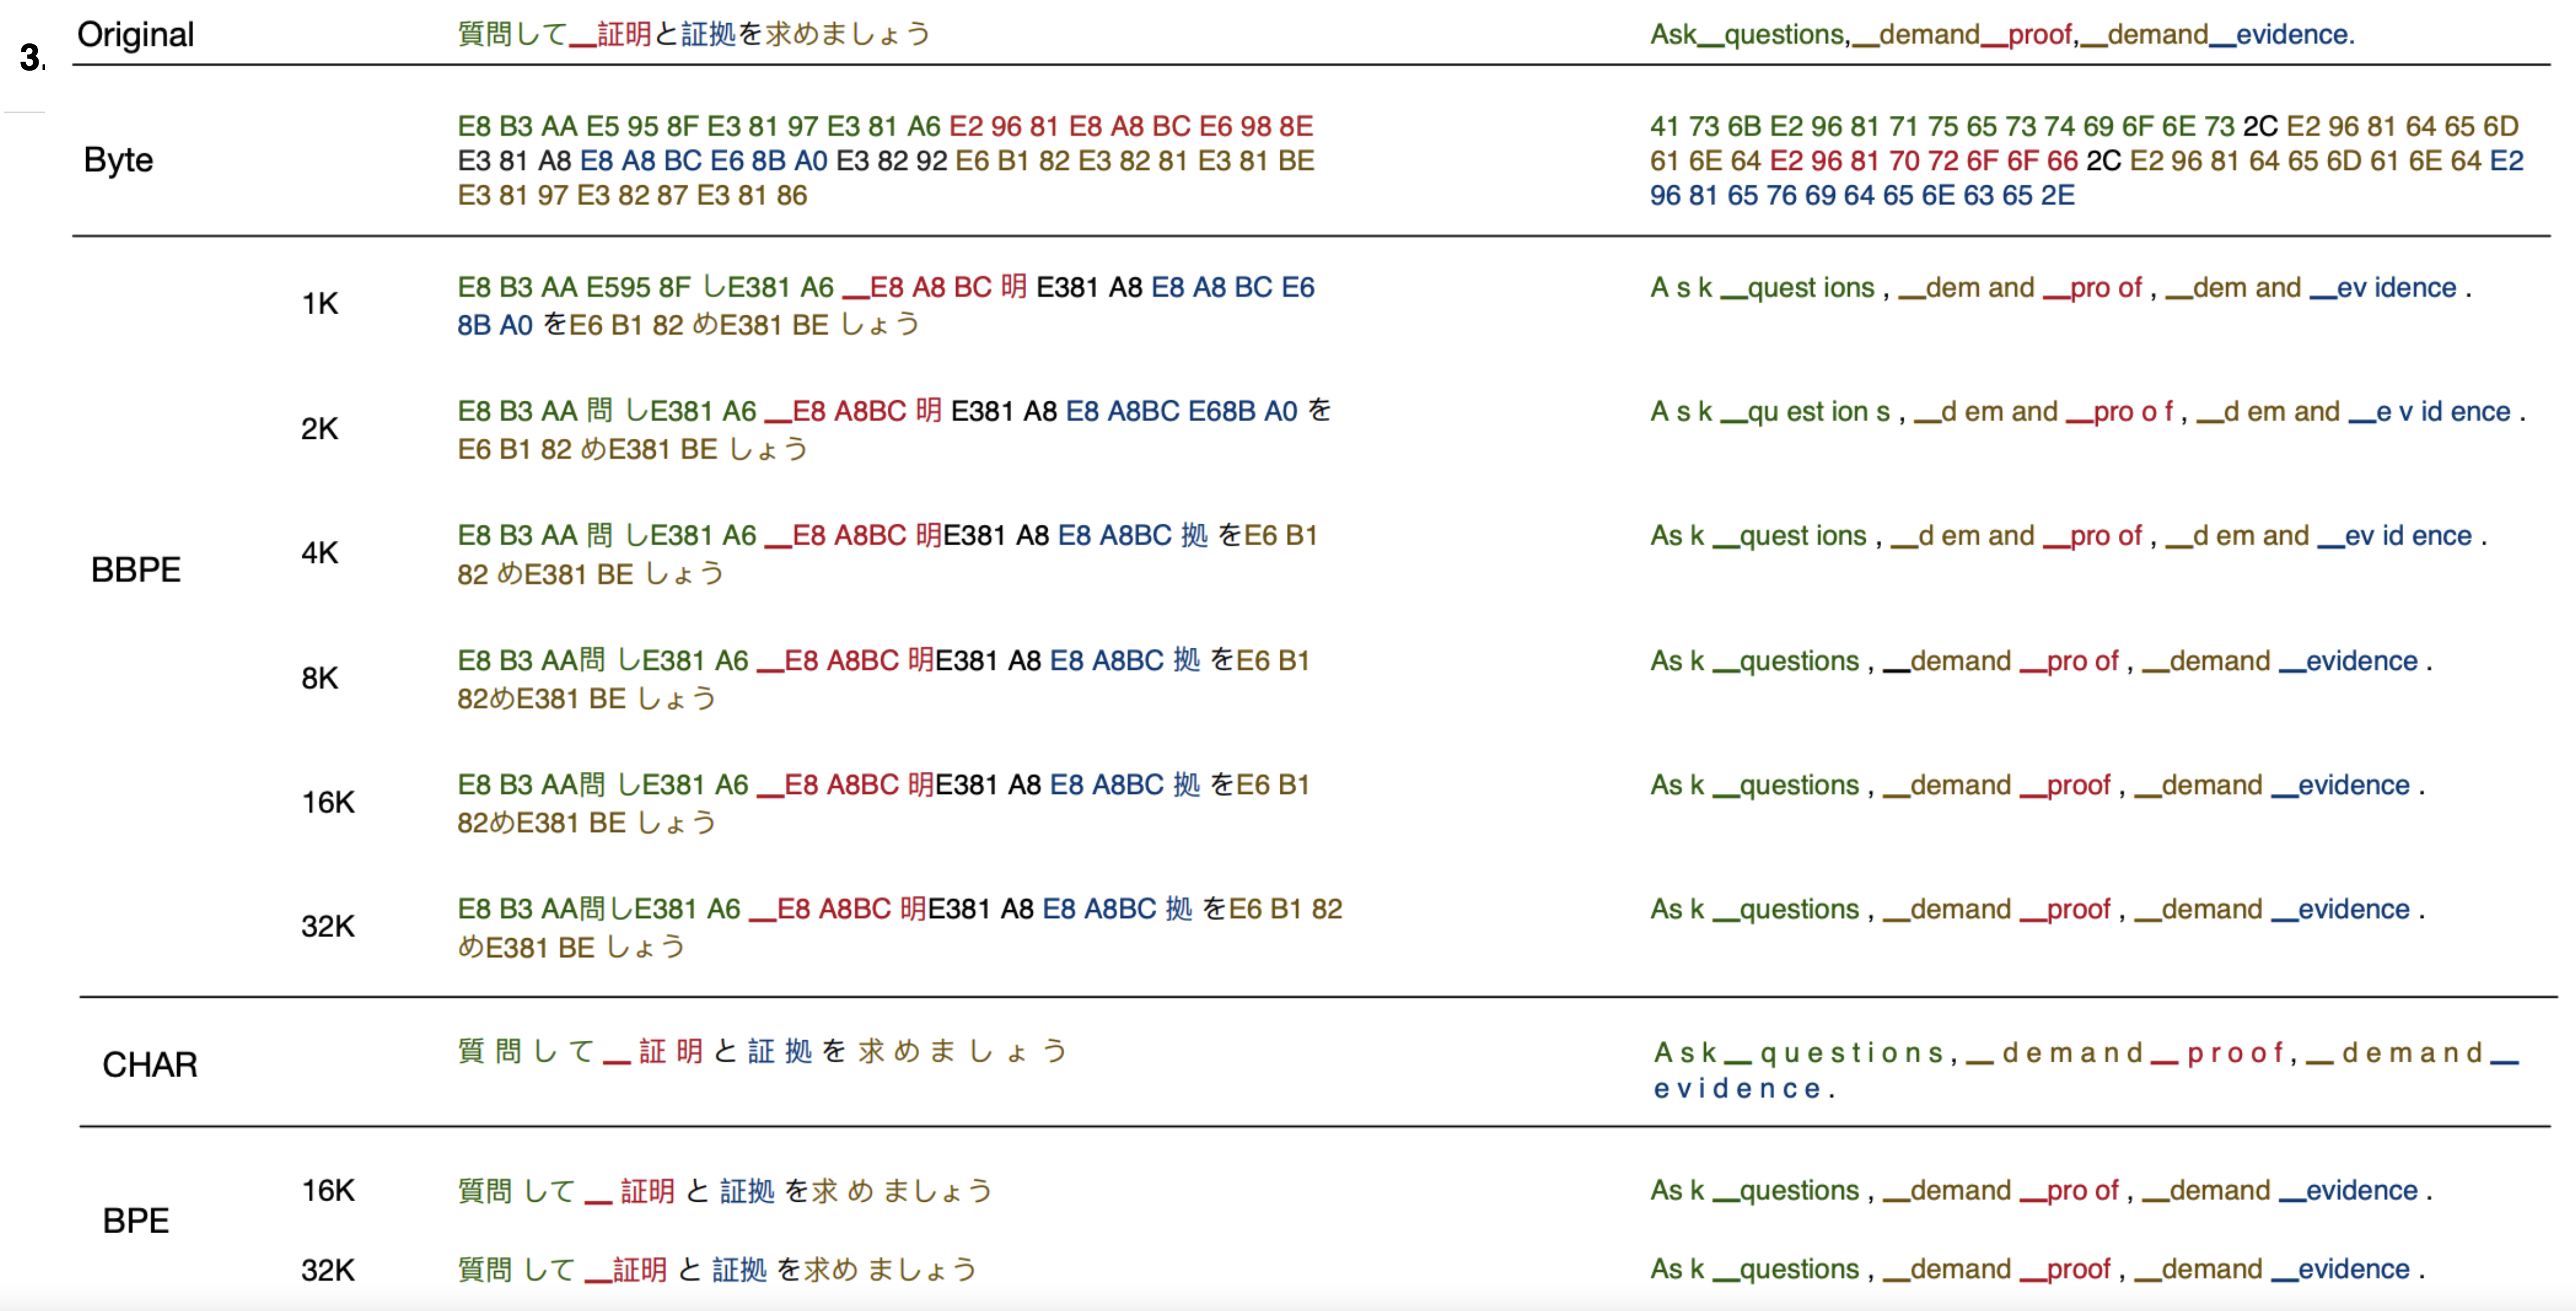

#### Contributions
- Byte-level subword vocabulary를 만드는 BBPE를 제안
- Character-based 기법에 비해서 성능을 유지하면서 vocabulary를 매우 작게 만들 수 있음
- Multilingual setting에서는 종종 더 성능이 좋기도 함
- OOV 문제도 전혀 없음
- 다양한 언어에 transferring도 가능하고, 이는 매우 generic하고 성능, training acceleration 면에서 이득이 있음 Character-based 기법보다 sequence length도 더 짧아서 빠른 학습과 추론이 가능함
